Successfully loaded robot_dataset.csv. Shape: (7409, 24)

Pre-processing Complete.
GLOBAL SPLIT: Train set size: 5186, Test set size: 2223
--------------------------------------------------

--- Task: Binary: Grip Lost (CV) ---
Target Distribution (Training Set):
grip_lost
0    5016
1     170
Name: count, dtype: int64
------------------------------
CV Results across 5 folds on TRAINING SET (Mean ± Std Dev):
  accuracy            : 0.8432 ± 0.0102
  f1_weighted         : 0.8883 ± 0.0061
  precision_weighted  : 0.9472 ± 0.0028
  recall_weighted     : 0.8432 ± 0.0102

--- Task: Binary: Protective Stop (CV) ---
Target Distribution (Training Set):
Robot_ProtectiveStop
0    4954
1     232
Name: count, dtype: int64
------------------------------
CV Results across 5 folds on TRAINING SET (Mean ± Std Dev):
  accuracy            : 0.5580 ± 0.0139
  f1_weighted         : 0.6762 ± 0.0119
  precision_weighted  : 0.9517 ± 0.0033
  recall_weighted     : 0.5580 ± 0.0139

--- Task: Multi-Class: Combine

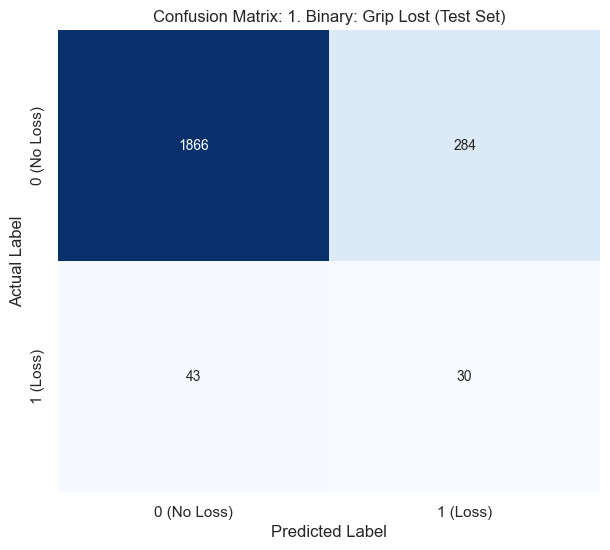


Numerical Confusion Matrix (Test Set):
                    Predicted 0 (No Loss)  Predicted 1 (Loss)
Actual 0 (No Loss)                   1866                 284
Actual 1 (Loss)                        43                  30

--- Final Model Evaluation: 2. Binary: Protective Stop ---
Final Accuracy on UNSEEN TEST SET: 0.5533

Classification Report (Test Set):
              precision    recall  f1-score   support

 0 (No Stop)       0.99      0.54      0.70      2123
    1 (Stop)       0.09      0.92      0.16       100

    accuracy                           0.55      2223
   macro avg       0.54      0.73      0.43      2223
weighted avg       0.95      0.55      0.67      2223



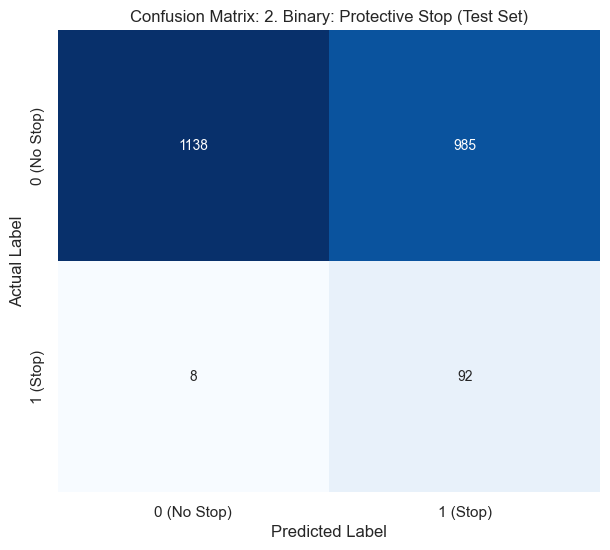


Numerical Confusion Matrix (Test Set):
                    Predicted 0 (No Stop)  Predicted 1 (Stop)
Actual 0 (No Stop)                   1138                 985
Actual 1 (Stop)                         8                  92

--- Final Model Evaluation: 3. Multi-Class: Combined Fault ---
Final Accuracy on UNSEEN TEST SET: 0.4507

Classification Report (Test Set):
                       precision    recall  f1-score   support

     (0, 0) No Faults       0.96      0.43      0.59      2051
 (0, 1) GripLost Only       0.11      0.40      0.18        72
(1, 0) RobotStop Only       0.09      0.92      0.16        99
   (1, 1) Both Faults       0.00      0.00      0.00         1

             accuracy                           0.45      2223
            macro avg       0.29      0.44      0.23      2223
         weighted avg       0.89      0.45      0.56      2223



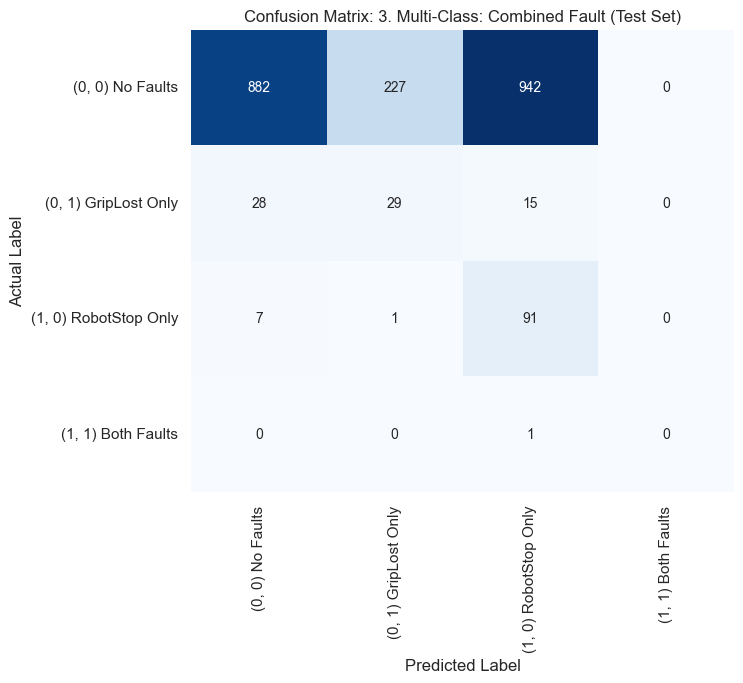


Numerical Confusion Matrix (Test Set):
                              Predicted (0, 0) No Faults  Predicted (0, 1) GripLost Only  Predicted (1, 0) RobotStop Only  Predicted (1, 1) Both Faults
Actual (0, 0) No Faults                              882                             227                              942                             0
Actual (0, 1) GripLost Only                           28                              29                               15                             0
Actual (1, 0) RobotStop Only                           7                               1                               91                             0
Actual (1, 1) Both Faults                              0                               0                                1                             0


In [3]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from warnings import filterwarnings

# --- IMPORTS FOR VISUALIZATION ---
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot styles
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (7, 6) # Adjusted size for better matrix display
plt.rcParams['font.size'] = 10
# ------------------------------------

# Suppress warnings that often occur with severely imbalanced data and zero division
filterwarnings('ignore')

# --- CONFIGURATION ---
FILE_NAME = "robot_dataset.csv"
RANDOM_STATE = 42
N_SPLITS = 5 # Number of folds for cross-validation

# --- 1. Data Loading and Initial Pre-processing ---

try:
    df = pd.read_csv(FILE_NAME)
    print(f"Successfully loaded {FILE_NAME}. Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: File '{FILE_NAME}' not found. Please ensure it is in the correct directory.")
    exit()

# Drop non-feature columns
df.drop(['Num', 'Timestamp'], axis=1, inplace=True)

# Encode Boolean/Object Fault Columns to Integers (0 or 1)
df['Robot_ProtectiveStop'] = df['Robot_ProtectiveStop'].astype(bool).astype(int)
df['grip_lost'] = df['grip_lost'].astype(int)

# Create the new combined target variable (4 Classes) - Must be done before the split
df['Combined_Fault'] = 2 * df['Robot_ProtectiveStop'] + df['grip_lost']

# Handle Missing Values (Imputation)
numerical_cols = df.select_dtypes(include=['float64']).columns
for col in numerical_cols:
    df[col].fillna(df[col].mean(), inplace=True)

# Prepare all features (X) and all targets (Y)
BASE_FEATURES = df.drop(['Robot_ProtectiveStop', 'grip_lost', 'Combined_Fault'], axis=1)
ALL_TARGETS = df[['grip_lost', 'Robot_ProtectiveStop', 'Combined_Fault']]

# --- GLOBAL TRAIN/TEST SPLIT (50/50) ---
# We stratify on the most complex target (Combined_Fault) to ensure all four classes
# are represented in both the training and test sets.
X_train, X_test, Y_train, Y_test = train_test_split(
    BASE_FEATURES, 
    ALL_TARGETS, 
    test_size=0.3, 
    random_state=RANDOM_STATE, 
    stratify=ALL_TARGETS['Combined_Fault']
)

# Extract individual target series for convenience
y_train_gl = Y_train['grip_lost']
y_test_gl = Y_test['grip_lost']

y_train_rps = Y_train['Robot_ProtectiveStop']
y_test_rps = Y_test['Robot_ProtectiveStop']

y_train_comb = Y_train['Combined_Fault']
y_test_comb = Y_test['Combined_Fault']


print("\nPre-processing Complete.")
print(f"GLOBAL SPLIT: Train set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")
print("-" * 50)


# --- 2. Define the Classification Functions ---

def run_cross_validation(X, y, target_name, model, n_splits=N_SPLITS):
    """Performs Stratified K-Fold Cross-Validation on the TRAINING set."""

    print(f"\n--- Task: {target_name} ---")
    print(f"Target Distribution (Training Set):\n{y.value_counts().sort_index()}")
    print("-" * 30)

    cv_strategy = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    scoring = {
        'accuracy': 'accuracy',
        'f1_weighted': 'f1_weighted',
        'precision_weighted': 'precision_weighted',
        'recall_weighted': 'recall_weighted'
    }

    # Perform cross-validation ONLY on X_train and y_train
    cv_results = cross_validate(model, X, y, cv=cv_strategy, scoring=scoring, n_jobs=-1)

    mean_results = {key: cv_results[f'test_{key}'].mean() for key in scoring}
    std_results = {key: cv_results[f'test_{key}'].std() for key in scoring}

    print(f"CV Results across {n_splits} folds on TRAINING SET (Mean ± Std Dev):")
    for metric, mean_val in mean_results.items():
        std_val = std_results[metric]
        print(f"  {metric:<20}: {mean_val:.4f} ± {std_val:.4f}")

    return mean_results, cv_results

# --- 3. Classification Tasks (Cross-Validation on TRAINING SET) ---

model_nb = GaussianNB()

# CV 1: Grip Lost
metrics_gl, _ = run_cross_validation(X_train, y_train_gl, 'Binary: Grip Lost (CV)', model_nb)

# CV 2: Protective Stop
metrics_rps, _ = run_cross_validation(X_train, y_train_rps, 'Binary: Protective Stop (CV)', model_nb)

# CV 3: Combined Fault
metrics_comb, _ = run_cross_validation(X_train, y_train_comb, 'Multi-Class: Combined Fault (CV)', model_nb)


# --- 4. Final Summary Table (Based on CV on TRAINING SET) ---

print("\n\n======================================================================")
print("  SUMMARY OF MODEL STABILITY (GAUSSIAN NB CV ON TRAINING SET)")
print("======================================================================")

print(f"{'Metric':<20} | {'Grip Lost':<15} | {'Protective Stop':<20} | {'Combined Fault':<15}")
print("-" * 75)

print(f"{'Mean CV Accuracy':<20} | "
      f"{metrics_gl['accuracy']:.4f} | "
      f"{metrics_rps['accuracy']:.4f} | "
      f"{metrics_comb['accuracy']:.4f}")

print(f"{'Mean CV F1-Score (W)':<20} | "
      f"{metrics_gl['f1_weighted']:.4f} | "
      f"{metrics_rps['f1_weighted']:.4f} | "
      f"{metrics_comb['f1_weighted']:.4f}")

print("\nConclusion: The Combined Fault task shows the poorest stability and performance on the training data,")
print("making it the most challenging classification problem.")


# --- 5. Final Evaluation on UNSEEN TEST SET ---

# --- Helper function for plotting the Confusion Matrix ---
def plot_confusion_matrix(cm, class_names, title):
    """Plots the confusion matrix using Seaborn."""
    plt.figure(figsize=(7, 6))
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False
    )
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()


# --- Helper function to train/evaluate the final model ---
def evaluate_final_model(X_train, y_train, X_test, y_test, target_name, class_names):
    """Trains model on X_train/y_train and evaluates on X_test/y_test."""
    
    # Instantiate a new model instance
    model = GaussianNB()
    
    # 1. TRAIN on the full training set
    model.fit(X_train, y_train)
    
    # 2. PREDICT and EVALUATE on the UNSEEN test set
    y_pred = model.predict(X_test) 
    
    print(f"\n--- Final Model Evaluation: {target_name} ---")
    print(f"Final Accuracy on UNSEEN TEST SET: {accuracy_score(y_test, y_pred):.4f}")
    
    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_pred, target_names=class_names, zero_division=0))

    # Calculate and Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, class_names, f'Confusion Matrix: {target_name} (Test Set)')
    
    # Print numerical matrix for reference
    cm_df = pd.DataFrame(
        cm, 
        index=[f'Actual {c}' for c in class_names], 
        columns=[f'Predicted {c}' for c in class_names]
    )
    print("\nNumerical Confusion Matrix (Test Set):")
    print(cm_df.to_string())


print("\n\n=======================================================")
print("  FINAL EVALUATION ON UNSEEN TEST SET")
print("=======================================================")


# 5a. Final Report for Grip Lost
evaluate_final_model(
    X_train, y_train_gl, X_test, y_test_gl, 
    '1. Binary: Grip Lost', 
    ['0 (No Loss)', '1 (Loss)']
)

# 5b. Final Report for Protective Stop
evaluate_final_model(
    X_train, y_train_rps, X_test, y_test_rps, 
    '2. Binary: Protective Stop', 
    ['0 (No Stop)', '1 (Stop)']
)

# 5c. Final Report for Combined Fault
target_names_full = [
    '(0, 0) No Faults',
    '(0, 1) GripLost Only',
    '(1, 0) RobotStop Only',
    '(1, 1) Both Faults'
]
evaluate_final_model(
    X_train, y_train_comb, X_test, y_test_comb,
    '3. Multi-Class: Combined Fault',
    target_names_full
)